In [16]:
import fitz  # PyMuPDF: PDF 텍스트 추출용
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

def extract_text_from_pdf(pdf_path):
    """PDF 파일에서 전체 텍스트 추출"""
    doc = fitz.open(pdf_path)
    full_text = ""
    for page in doc:
        full_text += page.get_text()
    return full_text

# PDF 파일 경로 (예: 애플 PDF)
pdf_path = "./pdf_filings/AAPL/2023-11-02_10-K_aapl-20230930.htm.pdf"
full_text = extract_text_from_pdf(pdf_path)
print("전체 텍스트 길이:", len(full_text))

model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# 전체 텍스트를 512 토큰 청크로 분할 (stride 사용)
encoding = tokenizer(
    full_text,
    max_length=512,
    truncation=True,
    return_overflowing_tokens=True,
    stride=50
)

# 각 청크를 안전하게 510 토큰으로 제한 (special tokens 추가하면 512 토큰 이하가 됨)
safe_chunks = [tokenizer.decode(enc.ids[:500], skip_special_tokens=True) for enc in encoding.encodings]
print("안전하게 생성된 청크 개수:", len(safe_chunks))

# 각 청크에 대해 감정 분석 실행
results_per_chunk = [sentiment_analyzer(chunk) for chunk in safe_chunks]

# 결과 집계: 각 청크별 결과 평균 계산 (간단한 평균 방식)
positive_sum = 0.0
negative_sum = 0.0
neutral_sum  = 0.0
chunk_count  = 0

for result in results_per_chunk:
    for res in result:
        label = res['label'].lower()
        score = res['score']
        if label == 'positive':
            positive_sum += score
        elif label == 'negative':
            negative_sum += score
        elif label == 'neutral':
            neutral_sum += score
    chunk_count += 1

avg_positive = positive_sum / chunk_count
avg_negative = negative_sum / chunk_count
avg_neutral  = neutral_sum  / chunk_count

print("전체 감정 분석 결과 (청크 평균):")
print(f"긍정 점수: {avg_positive:.4f}")
print(f"부정 점수: {avg_negative:.4f}")
print(f"중립 점수: {avg_neutral:.4f}")

# 각 청크 결과도 출력 (옵션)
for i, res in enumerate(results_per_chunk):
    print(f"청크 {i+1}: {res}")


전체 텍스트 길이: 201124


Device set to use mps:0


안전하게 생성된 청크 개수: 87
전체 감정 분석 결과 (청크 평균):
긍정 점수: 0.0000
부정 점수: 0.2758
중립 점수: 0.7043
청크 1: [{'label': 'Neutral', 'score': 0.9999980926513672}]
청크 2: [{'label': 'Neutral', 'score': 0.9998793601989746}]
청크 3: [{'label': 'Neutral', 'score': 0.999983549118042}]
청크 4: [{'label': 'Neutral', 'score': 0.9997754693031311}]
청크 5: [{'label': 'Neutral', 'score': 0.9999961853027344}]
청크 6: [{'label': 'Neutral', 'score': 0.9997513890266418}]
청크 7: [{'label': 'Neutral', 'score': 0.9561309218406677}]
청크 8: [{'label': 'Neutral', 'score': 0.9991639852523804}]
청크 9: [{'label': 'Neutral', 'score': 0.9953300952911377}]
청크 10: [{'label': 'Neutral', 'score': 0.9997302889823914}]
청크 11: [{'label': 'Negative', 'score': 0.9999850988388062}]
청크 12: [{'label': 'Negative', 'score': 0.9994403719902039}]
청크 13: [{'label': 'Negative', 'score': 0.9999358654022217}]
청크 14: [{'label': 'Negative', 'score': 0.9997660517692566}]
청크 15: [{'label': 'Negative', 'score': 0.8352388739585876}]
청크 16: [{'label': 'Negative', 'score':

In [17]:
import os
import time
from datetime import datetime
import fitz  # PyMuPDF
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# 1. PDF에서 텍스트 추출하는 함수
def extract_text_from_pdf(pdf_path):
    """주어진 PDF 파일에서 전체 텍스트 추출"""
    doc = fitz.open(pdf_path)
    full_text = ""
    for page in doc:
        full_text += page.get_text()
    return full_text

# 2. PDF 파일의 텍스트를 FinBERT로 감정 분석하는 함수
def analyze_sentiment_pdf(pdf_path, tokenizer, sentiment_analyzer):
    """
    주어진 PDF 파일에서 텍스트를 추출하고, 이를 500 토큰 이하 청크로 분할하여
    FinBERT로 감정 분석을 수행한 후, 각 청크의 감정 점수(긍정, 부정, 중립)를 평균내어 반환.
    전체 점수는 (긍정 - 부정)로 계산.
    """
    # PDF 텍스트 추출
    full_text = extract_text_from_pdf(pdf_path)
    
    # 전체 텍스트를 500 토큰 청크로 분할 (stride=50)
    encoding = tokenizer(
        full_text,
        max_length=500,
        truncation=True,
        return_overflowing_tokens=True,
        stride=50
    )
    
    # 각 청크를 안전하게 500 토큰 이하로 제한 (여기서는 처음 500 토큰 사용)
    safe_chunks = [tokenizer.decode(enc.ids[:500], skip_special_tokens=True) for enc in encoding.encodings]
    
    # 각 청크에 대해 감정 분석 실행
    results = []
    for chunk in safe_chunks:
        try:
            res = sentiment_analyzer(chunk)
            results.append(res)
        except Exception as e:
            print(f"Error analyzing chunk: {e}")
    
    # 각 청크 결과 집계 (각 청크 결과는 리스트 형태, 보통 하나의 dict가 포함됨)
    positive_sum = 0.0
    negative_sum = 0.0
    neutral_sum  = 0.0
    count = 0
    for res in results:
        for r in res:
            label = r['label'].lower()
            score = r['score']
            if label == 'positive':
                positive_sum += score
            elif label == 'negative':
                negative_sum += score
            elif label == 'neutral':
                neutral_sum += score
        count += 1
    if count == 0:
        return {'positive': None, 'negative': None, 'neutral': None, 'overall': None}
    
    avg_pos = positive_sum / count
    avg_neg = negative_sum / count
    avg_neu = neutral_sum / count
    overall = avg_pos - avg_neg
    return {'positive': avg_pos, 'negative': avg_neg, 'neutral': avg_neu, 'overall': overall}

In [18]:
import os
import time
from datetime import datetime
import fitz  # PyMuPDF
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# 1. PDF에서 텍스트 추출하는 함수
def extract_text_from_pdf(pdf_path):
    """주어진 PDF 파일에서 전체 텍스트 추출"""
    doc = fitz.open(pdf_path)
    full_text = ""
    for page in doc:
        full_text += page.get_text()
    return full_text

# 2. PDF 파일의 텍스트를 FinBERT로 감정 분석하는 함수
def analyze_sentiment_pdf(pdf_path, tokenizer, sentiment_analyzer):
    """
    주어진 PDF 파일에서 텍스트를 추출하고, 이를 500 토큰 이하 청크로 분할하여
    FinBERT로 감정 분석을 수행한 후, 각 청크의 감정 점수(긍정, 부정, 중립)를 평균내어 반환.
    전체 점수는 (긍정 - 부정)로 계산.
    """
    # PDF 텍스트 추출
    full_text = extract_text_from_pdf(pdf_path)
    
    # 전체 텍스트를 500 토큰 청크로 분할 (stride=50)
    encoding = tokenizer(
        full_text,
        max_length=500,
        truncation=True,
        return_overflowing_tokens=True,
        stride=50
    )
    
    # 각 청크를 안전하게 500 토큰 이하로 제한 (여기서는 처음 500 토큰 사용)
    safe_chunks = [tokenizer.decode(enc.ids[:500], skip_special_tokens=True) for enc in encoding.encodings]
    
    # 각 청크에 대해 감정 분석 실행
    results = []
    for chunk in safe_chunks:
        try:
            res = sentiment_analyzer(chunk)
            results.append(res)
        except Exception as e:
            print(f"Error analyzing chunk: {e}")
    
    # 각 청크 결과 집계 (각 청크 결과는 리스트 형태, 보통 하나의 dict가 포함됨)
    positive_sum = 0.0
    negative_sum = 0.0
    neutral_sum  = 0.0
    count = 0
    for res in results:
        for r in res:
            label = r['label'].lower()
            score = r['score']
            if label == 'positive':
                positive_sum += score
            elif label == 'negative':
                negative_sum += score
            elif label == 'neutral':
                neutral_sum += score
        count += 1
    if count == 0:
        return {'positive': None, 'negative': None, 'neutral': None, 'overall': None}
    
    avg_pos = positive_sum / count
    avg_neg = negative_sum / count
    avg_neu = neutral_sum / count
    overall = avg_pos - avg_neg
    return {'positive': avg_pos, 'negative': avg_neg, 'neutral': avg_neu, 'overall': overall}

# 3. 모델 및 토크나이저 로드 (FinBERT)
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# 4. 애플(AAPL) 폴더 내 PDF 파일들을 순회하며 감정 분석 수행
results_list = []
aapl_dir = "./pdf_filings/AAPL"
for filename in os.listdir(aapl_dir):
    if filename.endswith(".pdf"):
        file_path = os.path.join(aapl_dir, filename)
        # 파일명 형식: YYYY-MM-DD_<formType>_<...>.pdf
        parts = filename.split("_")
        try:
            filing_date_str = parts[0]  # 예: "2023-11-02"
            form_type = parts[1]        # 예: "10-K" 또는 "10-Q"
            filing_date = datetime.strptime(filing_date_str, "%Y-%m-%d")
        except Exception as e:
            print(f"파일명 파싱 오류 ({filename}): {e}")
            continue
        
        print(f"Analyzing {filename} ...")
        sentiment = analyze_sentiment_pdf(file_path, tokenizer, sentiment_analyzer)
        results_list.append({
            "filename": filename,
            "filing_date": filing_date,
            "form_type": form_type,
            "positive": sentiment['positive'],
            "negative": sentiment['negative'],
            "neutral": sentiment['neutral'],
            "overall": sentiment['overall']
        })

# 결과 DataFrame 생성 및 정렬
df = pd.DataFrame(results_list)
df.sort_values("filing_date", inplace=True)
print(df)

Device set to use mps:0


Analyzing 2023-08-03_10-Q_aapl-20230701.htm.pdf ...
Analyzing 2023-05-04_10-Q_aapl-20230401.htm.pdf ...
Analyzing 2024-05-02_10-Q_aapl-20240330.htm.pdf ...
Analyzing 2025-01-31_10-Q_aapl-20241228.htm.pdf ...
Analyzing 2024-08-01_10-Q_aapl-20240629.htm.pdf ...
Analyzing 2023-02-02_10-Q_aapl-20221231.htm.pdf ...
Analyzing 2024-11-01_10-K_aapl-20240928.htm.pdf ...
Analyzing 2023-11-02_10-K_aapl-20230930.htm.pdf ...
Analyzing 2024-02-01_10-Q_aapl-20231230.htm.pdf ...
                                filename filing_date form_type  positive  \
5  2023-02-02_10-Q_aapl-20221231.htm.pdf  2023-02-02      10-Q  0.000000   
1  2023-05-04_10-Q_aapl-20230401.htm.pdf  2023-05-04      10-Q  0.000000   
0  2023-08-03_10-Q_aapl-20230701.htm.pdf  2023-08-03      10-Q  0.000000   
7  2023-11-02_10-K_aapl-20230930.htm.pdf  2023-11-02      10-K  0.000000   
8  2024-02-01_10-Q_aapl-20231230.htm.pdf  2024-02-01      10-Q  0.000000   
2  2024-05-02_10-Q_aapl-20240330.htm.pdf  2024-05-02      10-Q  0.000000   


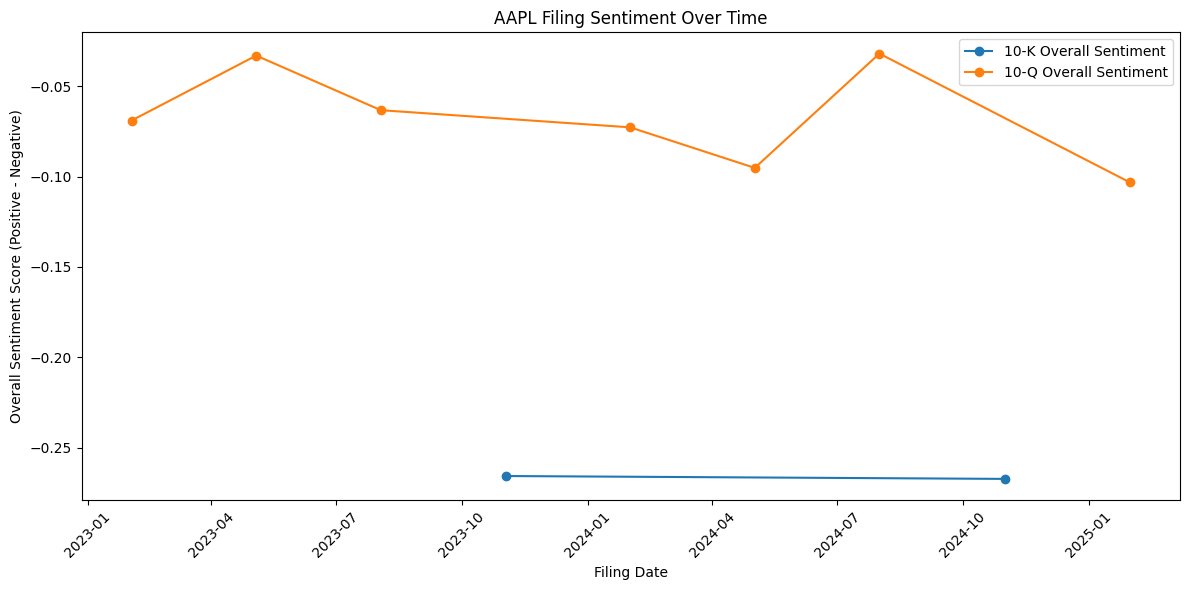

In [19]:

# 5. 기간별 감정 점수 그래프 그리기 (10-K와 10-Q 별로 분리)
df_10K = df[df["form_type"] == "10-K"]
df_10Q = df[df["form_type"] == "10-Q"]

plt.figure(figsize=(12,6))
plt.plot(df_10K["filing_date"], df_10K["overall"], marker='o', label="10-K Overall Sentiment")
plt.plot(df_10Q["filing_date"], df_10Q["overall"], marker='o', label="10-Q Overall Sentiment")
plt.xlabel("Filing Date")
plt.ylabel("Overall Sentiment Score (Positive - Negative)")
plt.title("AAPL Filing Sentiment Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
import os
import time
from datetime import datetime
import fitz  # PyMuPDF
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# 1. PDF에서 텍스트 추출 함수
def extract_text_from_pdf(pdf_path):
    """PDF 파일에서 전체 텍스트를 추출합니다."""
    doc = fitz.open(pdf_path)
    full_text = ""
    for page in doc:
        full_text += page.get_text()
    return full_text

# 2. PDF 파일에 대해 감정 분석 수행 함수
def analyze_sentiment_pdf(pdf_path, tokenizer, sentiment_analyzer):
    """
    PDF 파일에서 텍스트를 추출하고, 이를 500 토큰 이하 청크로 분할한 후 FinBERT를 사용하여
    감정 분석을 수행합니다. 전체 점수는 (긍정 - 부정)으로 계산합니다.
    """
    full_text = extract_text_from_pdf(pdf_path)
    # 전체 텍스트를 500 토큰 청크로 분할 (stride=50)
    encoding = tokenizer(
        full_text,
        max_length=500,
        truncation=True,
        return_overflowing_tokens=True,
        stride=50
    )
    # 각 청크를 안전하게 500 토큰 이하로 제한하여 디코딩
    safe_chunks = [tokenizer.decode(enc.ids[:500], skip_special_tokens=True) for enc in encoding.encodings]
    
    # 각 청크에 대해 감정 분석 실행
    results = []
    for chunk in safe_chunks:
        try:
            res = sentiment_analyzer(chunk)
            results.append(res)
        except Exception as e:
            print(f"Error analyzing chunk: {e}")
    
    # 청크별 결과 집계
    positive_sum = 0.0
    negative_sum = 0.0
    neutral_sum  = 0.0
    count = 0
    for res in results:
        for r in res:
            label = r['label'].lower()
            score = r['score']
            if label == 'positive':
                positive_sum += score
            elif label == 'negative':
                negative_sum += score
            elif label == 'neutral':
                neutral_sum += score
        count += 1
    if count == 0:
        return {'positive': None, 'negative': None, 'neutral': None, 'overall': None}
    avg_pos = positive_sum / count
    avg_neg = negative_sum / count
    avg_neu = neutral_sum / count
    overall = avg_pos - avg_neg
    return {'positive': avg_pos, 'negative': avg_neg, 'neutral': avg_neu, 'overall': overall}

# 3. 모델 및 파이프나이저 로드 (FinBERT)
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# 4. 특정 티커의 폴더를 순회하여 모든 PDF 파일에 대해 감정 분석 수행
def process_ticker(ticker, base_dir="./pdf_filings"):
    """
    지정한 티커(예: AMZN, AVGO)에 대해 해당 폴더 내의 모든 PDF 파일을 순회하며,
    파일명에서 리포트 날짜와 폼 종류(10-K / 10-Q)를 파싱하고,
    감정 분석 결과(긍정, 부정, 중립, overall)를 DataFrame으로 반환합니다.
    """
    ticker_dir = os.path.join(base_dir, ticker)
    results = []
    for filename in os.listdir(ticker_dir):
        if filename.endswith(".pdf"):
            file_path = os.path.join(ticker_dir, filename)
            # 파일명 형식: YYYY-MM-DD_<formType>_<...>.pdf
            parts = filename.split("_")
            try:
                filing_date_str = parts[0]  # 예: "2023-11-02"
                form_type = parts[1]        # "10-K" 또는 "10-Q"
                filing_date = datetime.strptime(filing_date_str, "%Y-%m-%d")
            except Exception as e:
                print(f"파일명 파싱 오류 ({filename}): {e}")
                continue
            print(f"Analyzing {ticker} file: {filename} ...")
            sentiment = analyze_sentiment_pdf(file_path, tokenizer, sentiment_analyzer)
            results.append({
                "filename": filename,
                "filing_date": filing_date,
                "form_type": form_type,
                "positive": sentiment['positive'],
                "negative": sentiment['negative'],
                "neutral": sentiment['neutral'],
                "overall": sentiment['overall']
            })
    return pd.DataFrame(results)


Device set to use mps:0



=== Processing AMZN ===
Analyzing AMZN file: 2023-08-03_10-Q_amzn-20230630.htm.pdf ...
Analyzing AMZN file: 2023-04-27_10-Q_amzn-20230331.htm.pdf ...
Analyzing AMZN file: 2024-08-01_10-Q_amzn-20240630.htm.pdf ...
Analyzing AMZN file: 2024-10-31_10-Q_amzn-20240930.htm.pdf ...
Analyzing AMZN file: 2024-02-01_10-K_amzn-20231231.htm.pdf ...
Analyzing AMZN file: 2023-10-26_10-Q_amzn-20230930.htm.pdf ...
Analyzing AMZN file: 2024-04-30_10-Q_amzn-20240331.htm.pdf ...
Analyzing AMZN file: 2023-02-02_10-K_amzn-20221231.htm.pdf ...
Analyzing AMZN file: 2025-02-06_10-K_amzn-20241231.htm.pdf ...
                                filename filing_date form_type  positive  \
7  2023-02-02_10-K_amzn-20221231.htm.pdf  2023-02-02      10-K  0.040352   
1  2023-04-27_10-Q_amzn-20230331.htm.pdf  2023-04-27      10-Q  0.027232   
0  2023-08-03_10-Q_amzn-20230630.htm.pdf  2023-08-03      10-Q  0.026160   
5  2023-10-26_10-Q_amzn-20230930.htm.pdf  2023-10-26      10-Q  0.025083   
4  2024-02-01_10-K_amzn-2023

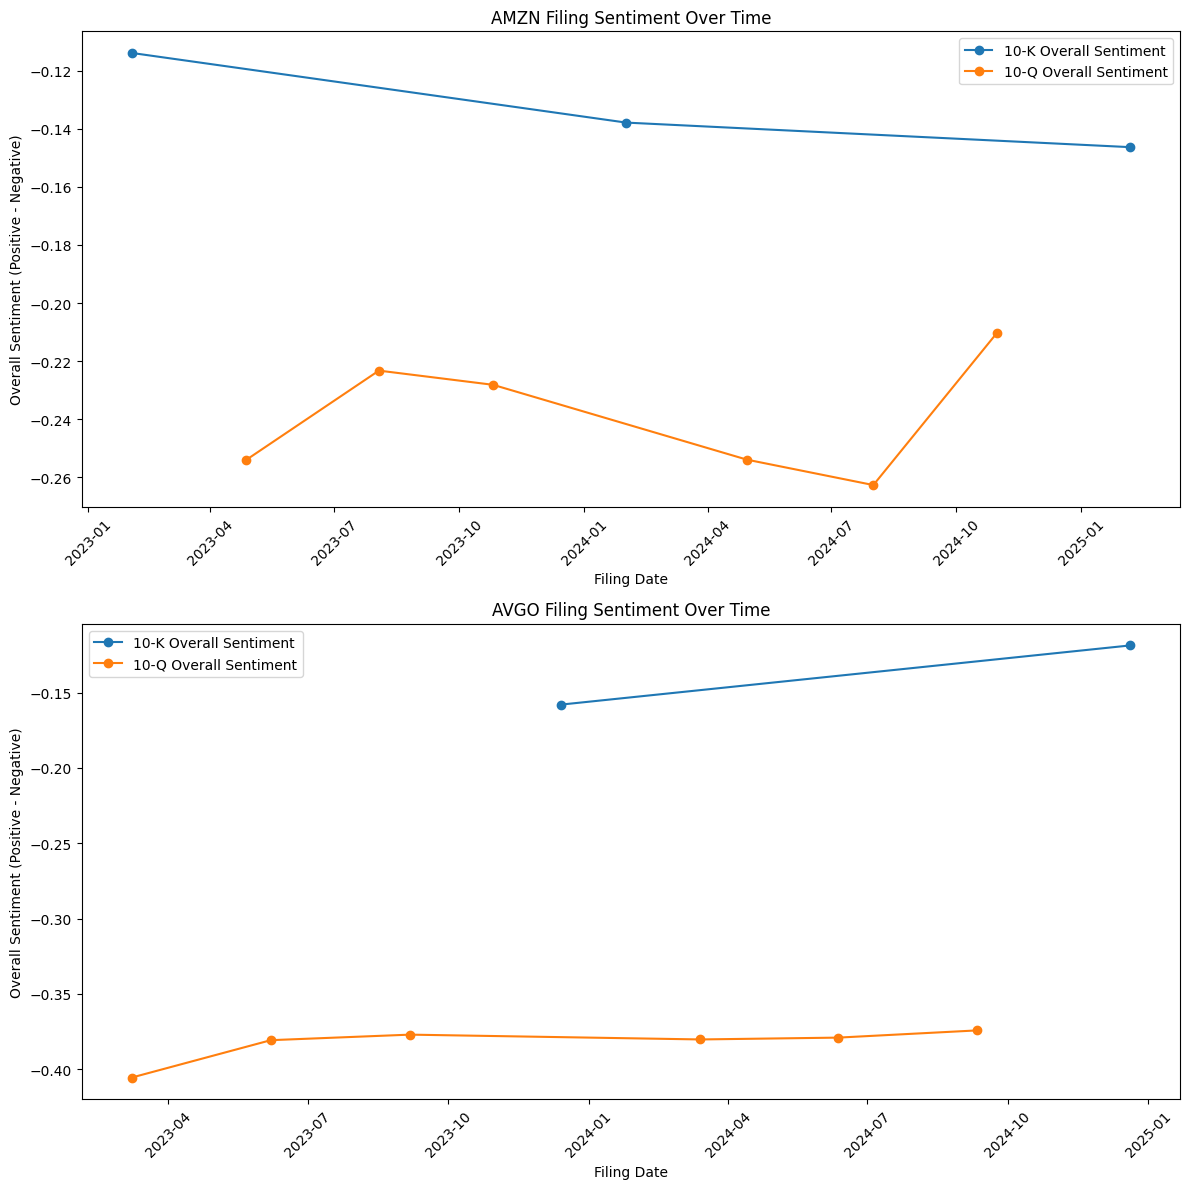

In [21]:
# 5. AMZN과 AVGO에 대해 처리
tickers_to_process = ["AMZN", "AVGO"]
dfs = {}
for ticker in tickers_to_process:
    print(f"\n=== Processing {ticker} ===")
    df = process_ticker(ticker)
    df.sort_values("filing_date", inplace=True)
    dfs[ticker] = df
    print(df)

# 6. 결과 시각화 (리포트 종류별로 분리하여)
fig, axs = plt.subplots(nrows=len(tickers_to_process), ncols=1, figsize=(12, 6*len(tickers_to_process)))
if len(tickers_to_process) == 1:
    axs = [axs]

for i, ticker in enumerate(tickers_to_process):
    df = dfs[ticker]
    # 10-K와 10-Q를 별도로 분리
    df_10K = df[df["form_type"] == "10-K"]
    df_10Q = df[df["form_type"] == "10-Q"]
    
    # 각 리포트 종류별 overall sentiment score (긍정 - 부정)를 시간에 따라 표시
    axs[i].plot(df_10K["filing_date"], df_10K["overall"], marker='o', label="10-K Overall Sentiment")
    axs[i].plot(df_10Q["filing_date"], df_10Q["overall"], marker='o', label="10-Q Overall Sentiment")
    axs[i].set_xlabel("Filing Date")
    axs[i].set_ylabel("Overall Sentiment (Positive - Negative)")
    axs[i].set_title(f"{ticker} Filing Sentiment Over Time")
    axs[i].legend()
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

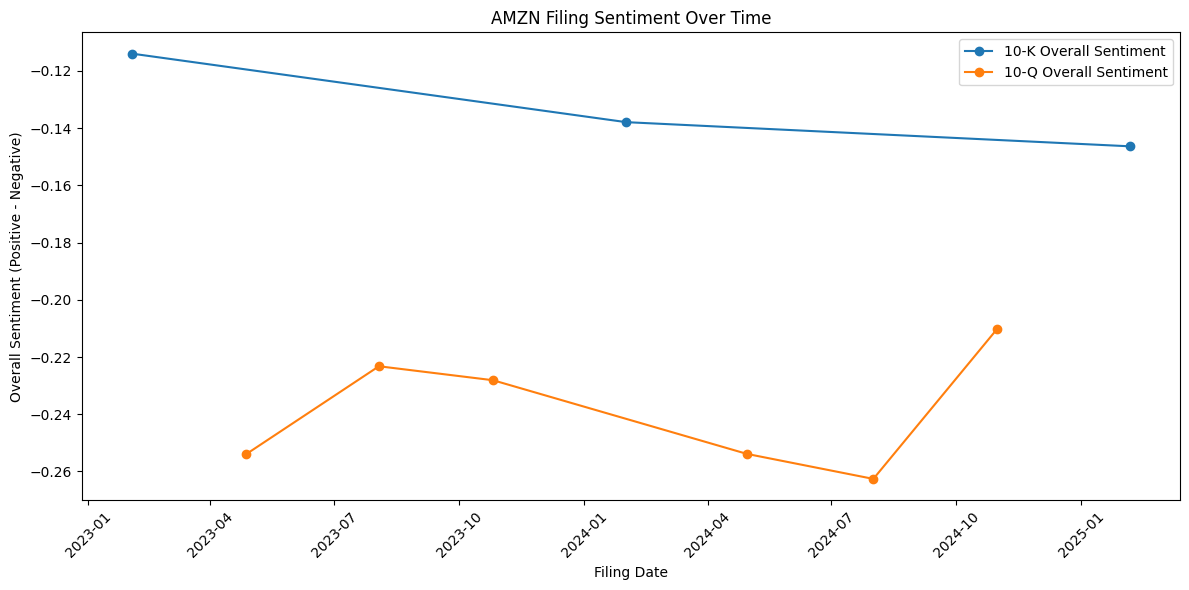

In [22]:
# AMZN DataFrame (이전 처리 결과 dfs 딕셔너리에서 "AMZN" 키 사용)
df_amzn = dfs["AMZN"]
df_amzn_10K = df_amzn[df_amzn["form_type"] == "10-K"]
df_amzn_10Q = df_amzn[df_amzn["form_type"] == "10-Q"]

plt.figure(figsize=(12,6))
plt.plot(df_amzn_10K["filing_date"], df_amzn_10K["overall"], marker='o', label="10-K Overall Sentiment")
plt.plot(df_amzn_10Q["filing_date"], df_amzn_10Q["overall"], marker='o', label="10-Q Overall Sentiment")
plt.xlabel("Filing Date")
plt.ylabel("Overall Sentiment (Positive - Negative)")
plt.title("AMZN Filing Sentiment Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

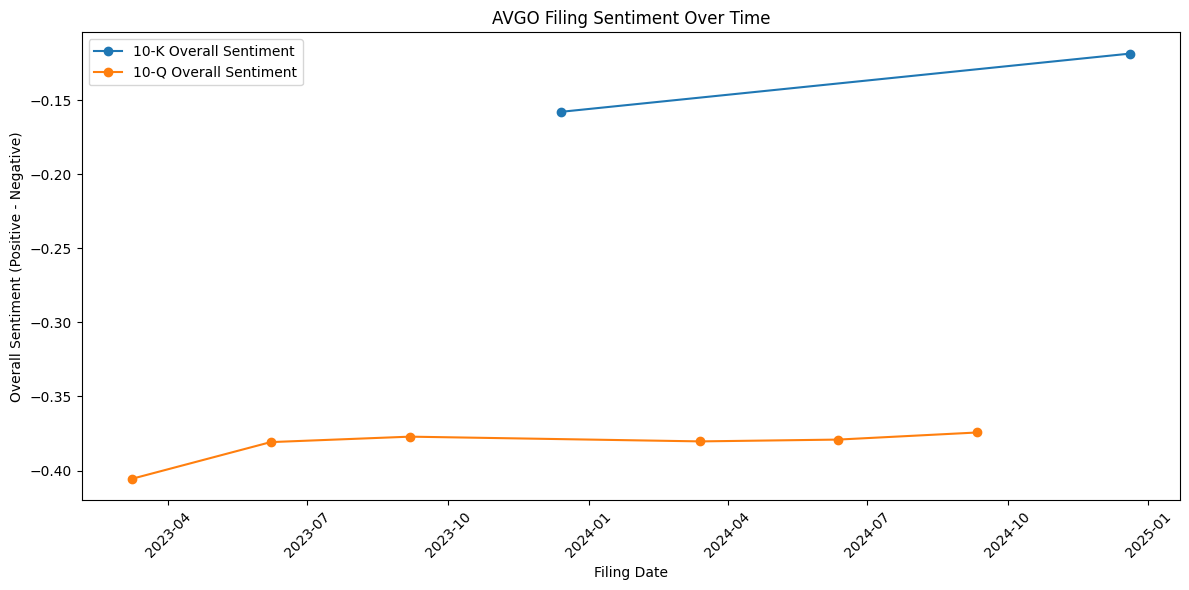

In [23]:
import matplotlib.pyplot as plt

# AVGO DataFrame (이전 처리 결과 dfs 딕셔너리에서 "AVGO" 키 사용)
df_avgo = dfs["AVGO"]
df_avgo_10K = df_avgo[df_avgo["form_type"] == "10-K"]
df_avgo_10Q = df_avgo[df_avgo["form_type"] == "10-Q"]

plt.figure(figsize=(12,6))
plt.plot(df_avgo_10K["filing_date"], df_avgo_10K["overall"], marker='o', label="10-K Overall Sentiment")
plt.plot(df_avgo_10Q["filing_date"], df_avgo_10Q["overall"], marker='o', label="10-Q Overall Sentiment")
plt.xlabel("Filing Date")
plt.ylabel("Overall Sentiment (Positive - Negative)")
plt.title("AVGO Filing Sentiment Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [25]:
import os
from datetime import datetime
import pandas as pd

# process_ticker 함수 정의 (이전 예제를 재사용)
def process_ticker(ticker, base_dir="./pdf_filings"):
    """
    지정한 티커의 PDF 파일들을 순회하며, 파일명에서 리포트 날짜와 폼 종류를 파싱하고,
    analyze_sentiment_pdf() 함수를 통해 감정 분석 결과(positive, negative, neutral, overall)를 얻어 DataFrame으로 반환합니다.
    """
    ticker_dir = os.path.join(base_dir, ticker)
    results = []
    if not os.path.isdir(ticker_dir):
        print(f"폴더가 존재하지 않습니다: {ticker_dir}")
        return pd.DataFrame()
    for filename in os.listdir(ticker_dir):
        if filename.endswith(".pdf"):
            file_path = os.path.join(ticker_dir, filename)
            # 파일명 형식 예: "2023-11-02_10-K_aapl-20230930.htm.pdf"
            parts = filename.split("_")
            try:
                filing_date_str = parts[0]  # 예: "2023-11-02"
                form_type = parts[1]        # "10-K" 또는 "10-Q"
                filing_date = datetime.strptime(filing_date_str, "%Y-%m-%d")
            except Exception as e:
                print(f"파일명 파싱 오류 ({filename}): {e}")
                continue
            print(f"[{ticker}] 분석 중: {filename} ...")
            sentiment = analyze_sentiment_pdf(file_path, tokenizer, sentiment_analyzer)
            results.append({
                "filename": filename,
                "filing_date": filing_date,
                "form_type": form_type,
                "positive": sentiment['positive'],
                "negative": sentiment['negative'],
                "neutral": sentiment['neutral'],
                "overall": sentiment['overall']
            })
    df = pd.DataFrame(results)
    df.sort_values("filing_date", inplace=True)
    return df

# 남은 회사 목록 (AAPL, AMZN, AVGO는 이미 진행됨)
remaining_tickers = ["BRK-A", "GOOGL", "META", "MSFT", "NVDA", "TSLA", "WMT"]

# 각 회사별 감정 분석 결과를 저장할 딕셔너리
results_dict = {}

for ticker in remaining_tickers:
    print(f"\n=== Processing {ticker} ===")
    df = process_ticker(ticker)
    results_dict[ticker] = df
    # 결과를 CSV로 저장 (원하면)
    output_csv = f"metadata_{ticker}.csv"
    df.to_csv(output_csv, index=False)
    print(f"✅ {ticker} 결과 CSV 생성: {output_csv}")

# 이제 results_dict에는 각 회사별 감정 분석 결과 DataFrame이 저장됩니다.
# 시각화는 나중에 각 셀에서 별도로 진행할 수 있습니다.



=== Processing BRK-A ===
[BRK-A] 분석 중: 2024-08-05_10-Q_brka-20240630.htm.pdf ...
[BRK-A] 분석 중: 2023-02-27_10-K_brka-20221231.htm.pdf ...
[BRK-A] 분석 중: 2023-08-07_10-Q_brka-20230630.htm.pdf ...
[BRK-A] 분석 중: 2023-05-08_10-Q_brka-20230331.htm.pdf ...
[BRK-A] 분석 중: 2023-11-06_10-Q_brka-20230930.htm.pdf ...
[BRK-A] 분석 중: 2024-05-06_10-Q_brka-20240331.htm.pdf ...
[BRK-A] 분석 중: 2024-11-04_10-Q_brka-20240930.htm.pdf ...
[BRK-A] 분석 중: 2024-02-26_10-K_brka-20231231.htm.pdf ...
✅ BRK-A 결과 CSV 생성: metadata_BRK-A.csv

=== Processing GOOGL ===
[GOOGL] 분석 중: 2023-07-25_10-Q_goog-20230630.htm.pdf ...
[GOOGL] 분석 중: 2024-01-30_10-K_goog-20231231.htm.pdf ...
[GOOGL] 분석 중: 2023-04-25_10-Q_goog-20230331.htm.pdf ...
[GOOGL] 분석 중: 2023-02-02_10-K_goog-20221231.htm.pdf ...
[GOOGL] 분석 중: 2024-10-29_10-Q_goog-20240930.htm.pdf ...
[GOOGL] 분석 중: 2023-10-24_10-Q_goog-20230930.htm.pdf ...
[GOOGL] 분석 중: 2024-04-25_10-Q_goog-20240331.htm.pdf ...
[GOOGL] 분석 중: 2024-07-23_10-Q_goog-20240630.htm.pdf ...
[GOOGL] 분석 중: 

In [27]:
tickers_previously = ["AAPL", "AMZN", "AVGO"]

for ticker in tickers_previously:
    print(f"Processing {ticker} ...")
    df = process_ticker(ticker)  # 해당 티커의 결과 DataFrame 생성
    output_csv = f"metadata_{ticker}.csv"
    df.to_csv(output_csv, index=False)
    print(f"✅ {ticker} 결과 CSV 파일이 생성되었습니다: {output_csv}")

Processing AAPL ...
[AAPL] 분석 중: 2023-08-03_10-Q_aapl-20230701.htm.pdf ...
[AAPL] 분석 중: 2023-05-04_10-Q_aapl-20230401.htm.pdf ...
[AAPL] 분석 중: 2024-05-02_10-Q_aapl-20240330.htm.pdf ...
[AAPL] 분석 중: 2025-01-31_10-Q_aapl-20241228.htm.pdf ...
[AAPL] 분석 중: 2024-08-01_10-Q_aapl-20240629.htm.pdf ...
[AAPL] 분석 중: 2023-02-02_10-Q_aapl-20221231.htm.pdf ...
[AAPL] 분석 중: 2024-11-01_10-K_aapl-20240928.htm.pdf ...
[AAPL] 분석 중: 2023-11-02_10-K_aapl-20230930.htm.pdf ...
[AAPL] 분석 중: 2024-02-01_10-Q_aapl-20231230.htm.pdf ...
✅ AAPL 결과 CSV 파일이 생성되었습니다: metadata_AAPL.csv
Processing AMZN ...
[AMZN] 분석 중: 2023-08-03_10-Q_amzn-20230630.htm.pdf ...
[AMZN] 분석 중: 2023-04-27_10-Q_amzn-20230331.htm.pdf ...
[AMZN] 분석 중: 2024-08-01_10-Q_amzn-20240630.htm.pdf ...
[AMZN] 분석 중: 2024-10-31_10-Q_amzn-20240930.htm.pdf ...
[AMZN] 분석 중: 2024-02-01_10-K_amzn-20231231.htm.pdf ...
[AMZN] 분석 중: 2023-10-26_10-Q_amzn-20230930.htm.pdf ...
[AMZN] 분석 중: 2024-04-30_10-Q_amzn-20240331.htm.pdf ...
[AMZN] 분석 중: 2023-02-02_10-K_amzn-2

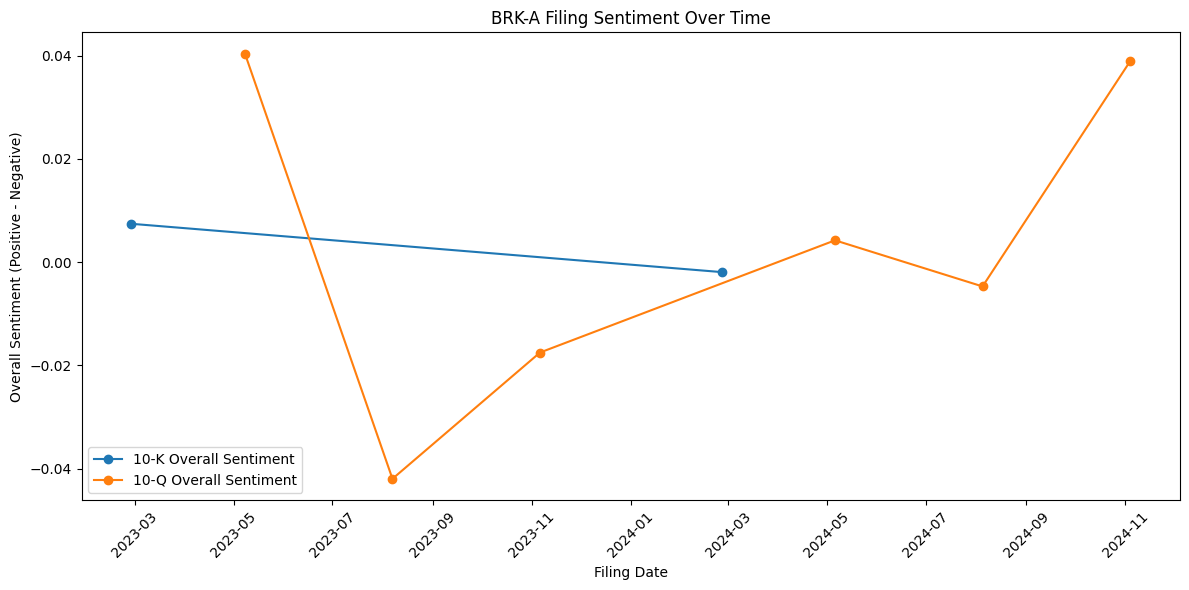

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 읽기 (파일 경로를 실제 파일명에 맞게 조정하세요)
df_brka = pd.read_csv("metadata_BRK-A.csv")
df_brka['filing_date'] = pd.to_datetime(df_brka['filing_date'])
df_brka.sort_values("filing_date", inplace=True)

# 10-K와 10-Q 분리
df_brka_10K = df_brka[df_brka["form_type"] == "10-K"]
df_brka_10Q = df_brka[df_brka["form_type"] == "10-Q"]

plt.figure(figsize=(12,6))
plt.plot(df_brka_10K["filing_date"], df_brka_10K["overall"], marker='o', label="10-K Overall Sentiment")
plt.plot(df_brka_10Q["filing_date"], df_brka_10Q["overall"], marker='o', label="10-Q Overall Sentiment")
plt.xlabel("Filing Date")
plt.ylabel("Overall Sentiment (Positive - Negative)")
plt.title("BRK-A Filing Sentiment Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


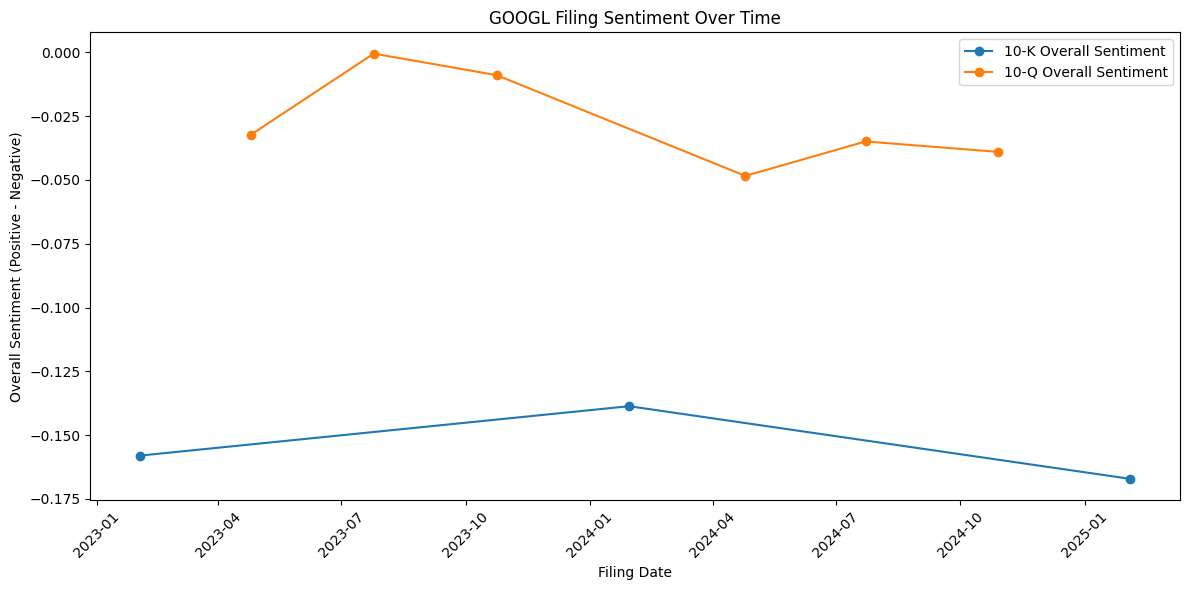

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

df_googl = pd.read_csv("metadata_GOOGL.csv")
df_googl['filing_date'] = pd.to_datetime(df_googl['filing_date'])
df_googl.sort_values("filing_date", inplace=True)

df_googl_10K = df_googl[df_googl["form_type"] == "10-K"]
df_googl_10Q = df_googl[df_googl["form_type"] == "10-Q"]

plt.figure(figsize=(12,6))
plt.plot(df_googl_10K["filing_date"], df_googl_10K["overall"], marker='o', label="10-K Overall Sentiment")
plt.plot(df_googl_10Q["filing_date"], df_googl_10Q["overall"], marker='o', label="10-Q Overall Sentiment")
plt.xlabel("Filing Date")
plt.ylabel("Overall Sentiment (Positive - Negative)")
plt.title("GOOGL Filing Sentiment Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


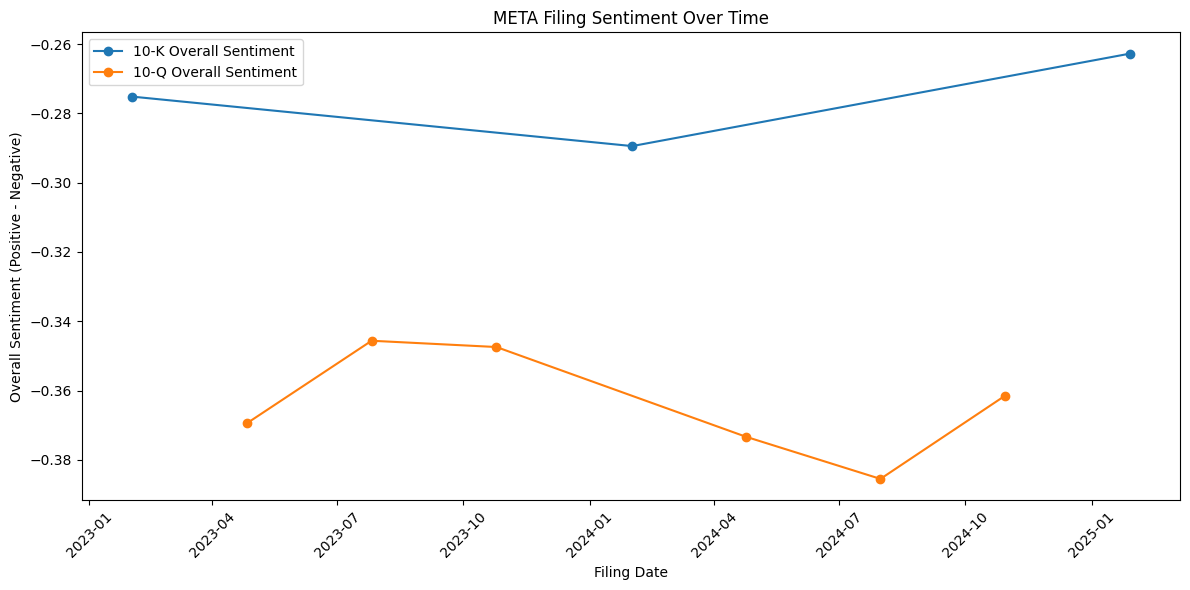

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

df_meta = pd.read_csv("metadata_META.csv")
df_meta['filing_date'] = pd.to_datetime(df_meta['filing_date'])
df_meta.sort_values("filing_date", inplace=True)

df_meta_10K = df_meta[df_meta["form_type"] == "10-K"]
df_meta_10Q = df_meta[df_meta["form_type"] == "10-Q"]

plt.figure(figsize=(12,6))
plt.plot(df_meta_10K["filing_date"], df_meta_10K["overall"], marker='o', label="10-K Overall Sentiment")
plt.plot(df_meta_10Q["filing_date"], df_meta_10Q["overall"], marker='o', label="10-Q Overall Sentiment")
plt.xlabel("Filing Date")
plt.ylabel("Overall Sentiment (Positive - Negative)")
plt.title("META Filing Sentiment Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


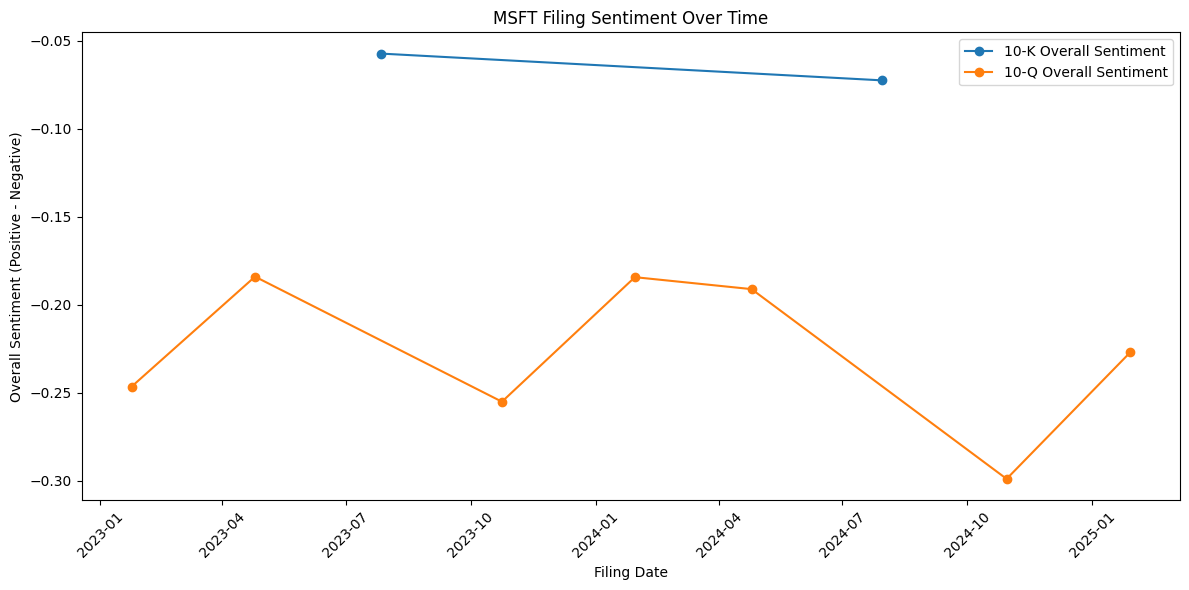

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

df_msft = pd.read_csv("metadata_MSFT.csv")
df_msft['filing_date'] = pd.to_datetime(df_msft['filing_date'])
df_msft.sort_values("filing_date", inplace=True)

df_msft_10K = df_msft[df_msft["form_type"] == "10-K"]
df_msft_10Q = df_msft[df_msft["form_type"] == "10-Q"]

plt.figure(figsize=(12,6))
plt.plot(df_msft_10K["filing_date"], df_msft_10K["overall"], marker='o', label="10-K Overall Sentiment")
plt.plot(df_msft_10Q["filing_date"], df_msft_10Q["overall"], marker='o', label="10-Q Overall Sentiment")
plt.xlabel("Filing Date")
plt.ylabel("Overall Sentiment (Positive - Negative)")
plt.title("MSFT Filing Sentiment Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


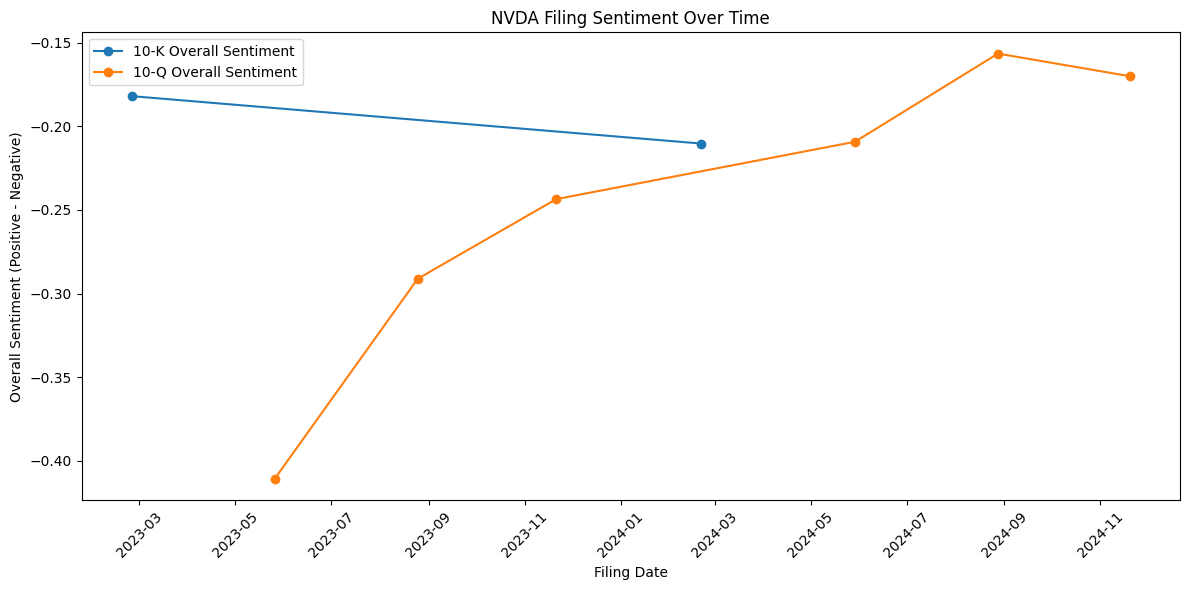

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

df_nvda = pd.read_csv("metadata_NVDA.csv")
df_nvda['filing_date'] = pd.to_datetime(df_nvda['filing_date'])
df_nvda.sort_values("filing_date", inplace=True)

df_nvda_10K = df_nvda[df_nvda["form_type"] == "10-K"]
df_nvda_10Q = df_nvda[df_nvda["form_type"] == "10-Q"]

plt.figure(figsize=(12,6))
plt.plot(df_nvda_10K["filing_date"], df_nvda_10K["overall"], marker='o', label="10-K Overall Sentiment")
plt.plot(df_nvda_10Q["filing_date"], df_nvda_10Q["overall"], marker='o', label="10-Q Overall Sentiment")
plt.xlabel("Filing Date")
plt.ylabel("Overall Sentiment (Positive - Negative)")
plt.title("NVDA Filing Sentiment Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


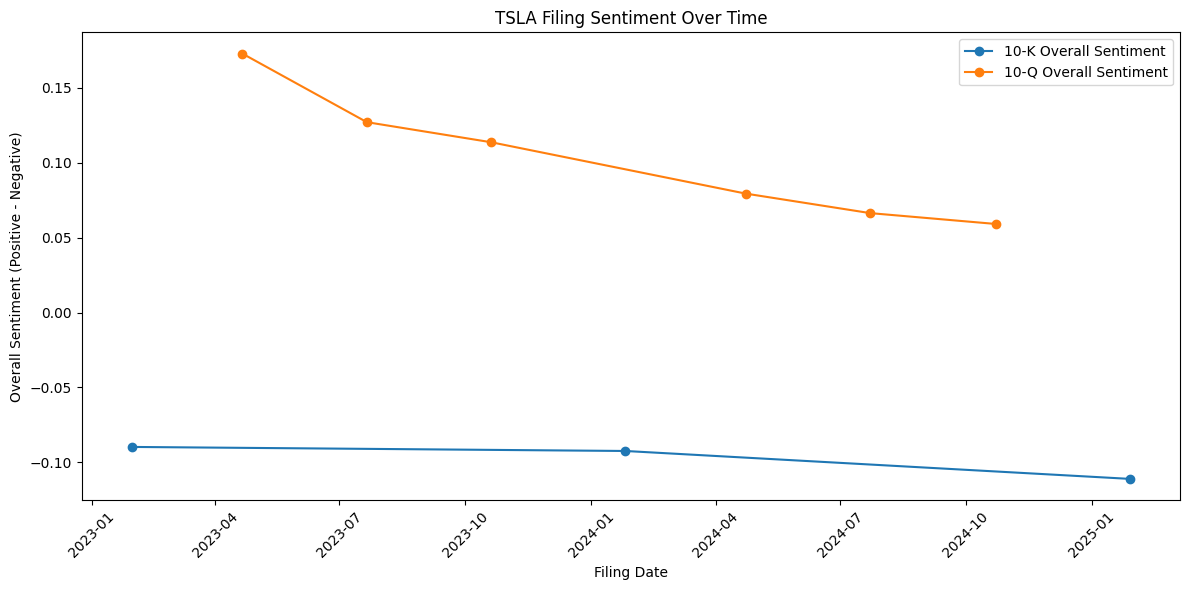

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

df_tsla = pd.read_csv("metadata_TSLA.csv")
df_tsla['filing_date'] = pd.to_datetime(df_tsla['filing_date'])
df_tsla.sort_values("filing_date", inplace=True)

df_tsla_10K = df_tsla[df_tsla["form_type"] == "10-K"]
df_tsla_10Q = df_tsla[df_tsla["form_type"] == "10-Q"]

plt.figure(figsize=(12,6))
plt.plot(df_tsla_10K["filing_date"], df_tsla_10K["overall"], marker='o', label="10-K Overall Sentiment")
plt.plot(df_tsla_10Q["filing_date"], df_tsla_10Q["overall"], marker='o', label="10-Q Overall Sentiment")
plt.xlabel("Filing Date")
plt.ylabel("Overall Sentiment (Positive - Negative)")
plt.title("TSLA Filing Sentiment Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


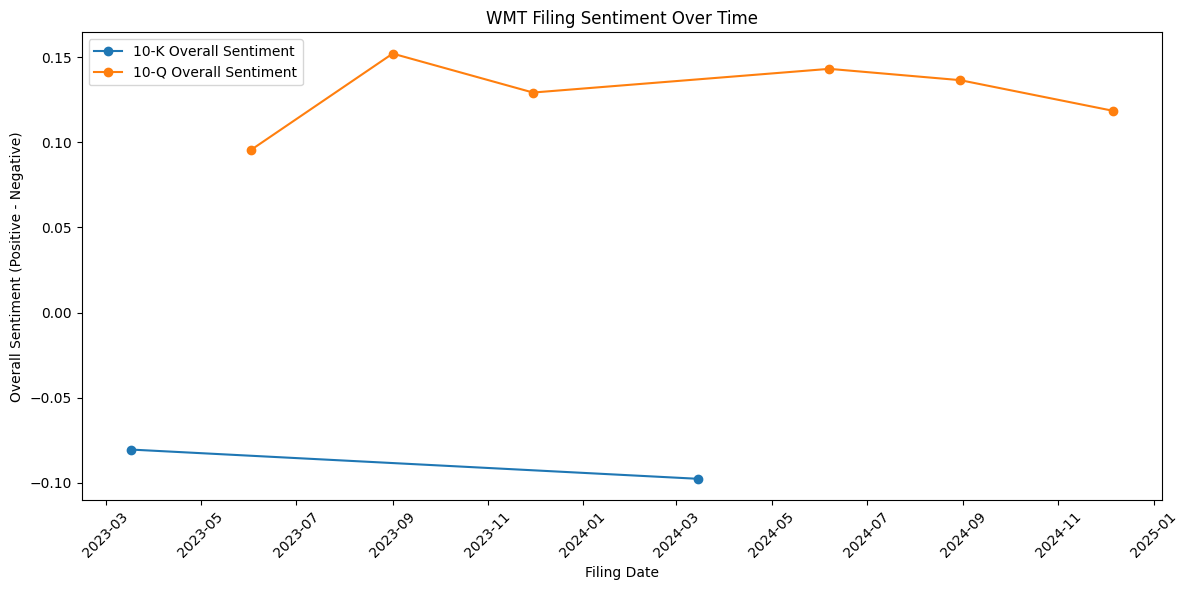

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

df_wmt = pd.read_csv("metadata_WMT.csv")
df_wmt['filing_date'] = pd.to_datetime(df_wmt['filing_date'])
df_wmt.sort_values("filing_date", inplace=True)

df_wmt_10K = df_wmt[df_wmt["form_type"] == "10-K"]
df_wmt_10Q = df_wmt[df_wmt["form_type"] == "10-Q"]

plt.figure(figsize=(12,6))
plt.plot(df_wmt_10K["filing_date"], df_wmt_10K["overall"], marker='o', label="10-K Overall Sentiment")
plt.plot(df_wmt_10Q["filing_date"], df_wmt_10Q["overall"], marker='o', label="10-Q Overall Sentiment")
plt.xlabel("Filing Date")
plt.ylabel("Overall Sentiment (Positive - Negative)")
plt.title("WMT Filing Sentiment Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


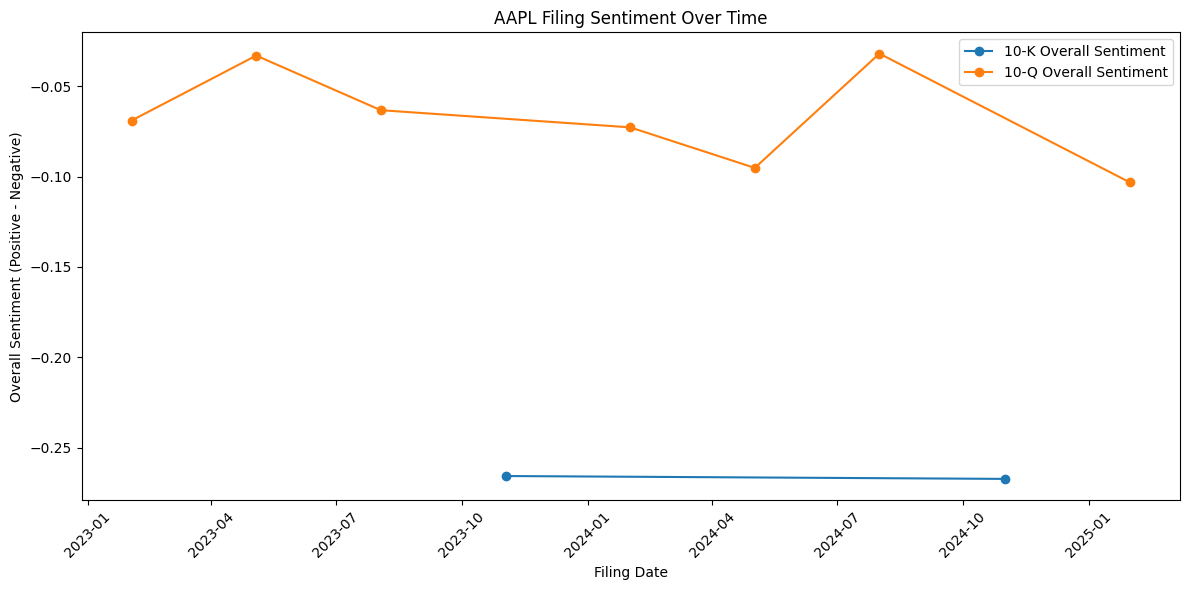

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

df_aapl = pd.read_csv("metadata_AAPL.csv")
df_aapl['filing_date'] = pd.to_datetime(df_aapl['filing_date'])
df_aapl.sort_values("filing_date", inplace=True)

df_aapl_10K = df_aapl[df_aapl["form_type"] == "10-K"]
df_aapl_10Q = df_aapl[df_aapl["form_type"] == "10-Q"]

plt.figure(figsize=(12,6))
plt.plot(df_aapl_10K["filing_date"], df_aapl_10K["overall"], marker='o', label="10-K Overall Sentiment")
plt.plot(df_aapl_10Q["filing_date"], df_aapl_10Q["overall"], marker='o', label="10-Q Overall Sentiment")
plt.xlabel("Filing Date")
plt.ylabel("Overall Sentiment (Positive - Negative)")
plt.title("AAPL Filing Sentiment Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


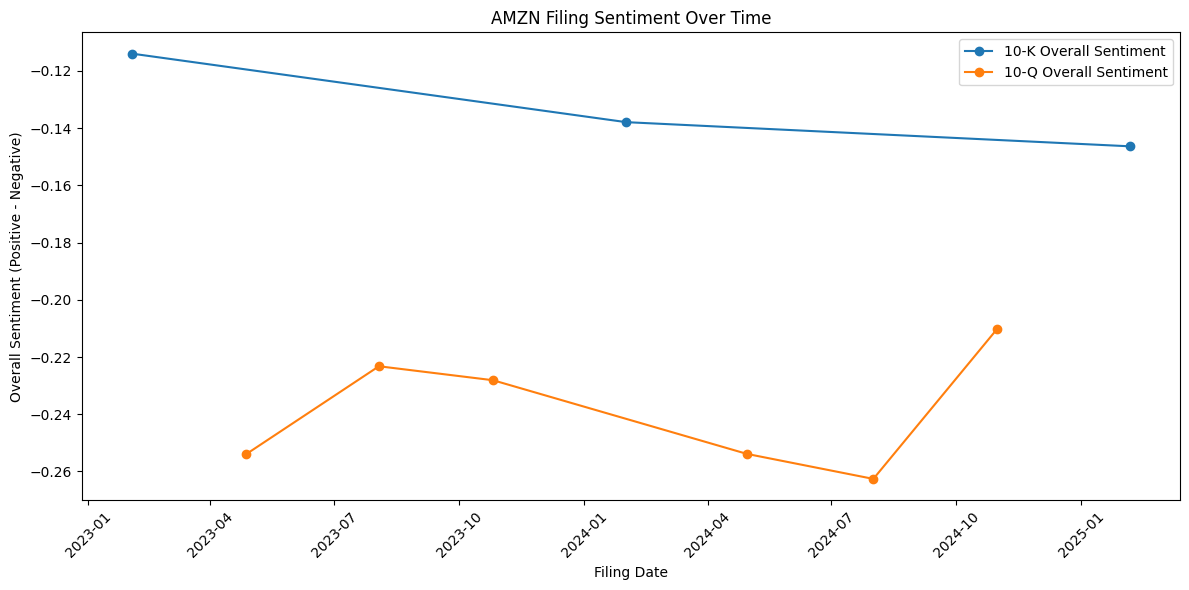

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

df_amzn = pd.read_csv("metadata_AMZN.csv")
df_amzn['filing_date'] = pd.to_datetime(df_amzn['filing_date'])
df_amzn.sort_values("filing_date", inplace=True)

df_amzn_10K = df_amzn[df_amzn["form_type"] == "10-K"]
df_amzn_10Q = df_amzn[df_amzn["form_type"] == "10-Q"]

plt.figure(figsize=(12,6))
plt.plot(df_amzn_10K["filing_date"], df_amzn_10K["overall"], marker='o', label="10-K Overall Sentiment")
plt.plot(df_amzn_10Q["filing_date"], df_amzn_10Q["overall"], marker='o', label="10-Q Overall Sentiment")
plt.xlabel("Filing Date")
plt.ylabel("Overall Sentiment (Positive - Negative)")
plt.title("AMZN Filing Sentiment Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


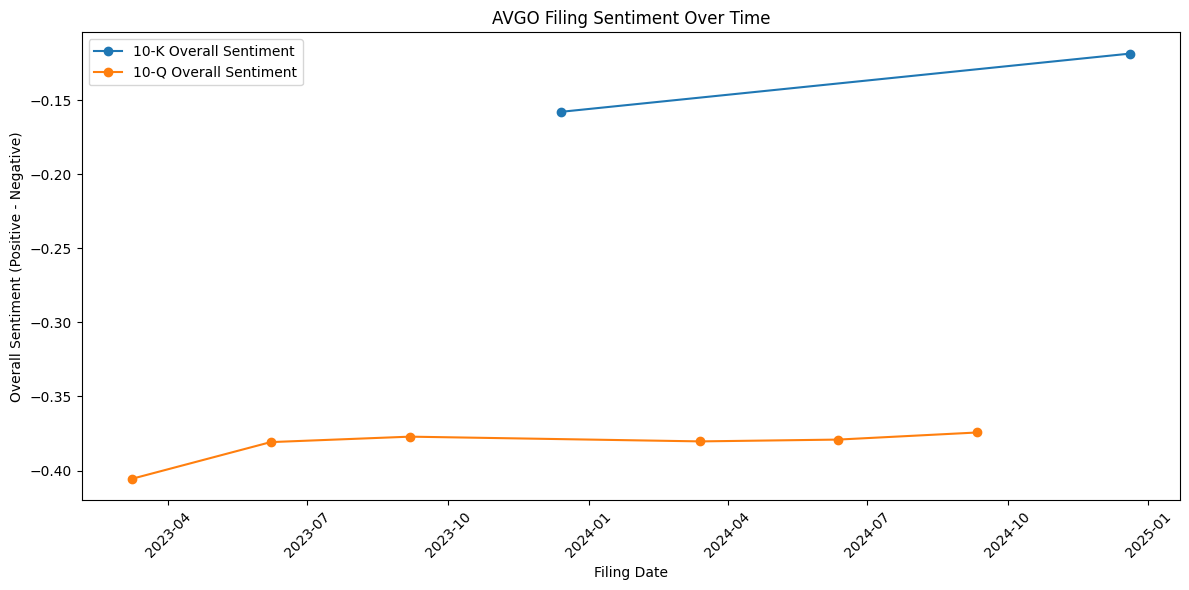

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

df_avgo = pd.read_csv("metadata_AVGO.csv")
df_avgo['filing_date'] = pd.to_datetime(df_avgo['filing_date'])
df_avgo.sort_values("filing_date", inplace=True)

df_avgo_10K = df_avgo[df_avgo["form_type"] == "10-K"]
df_avgo_10Q = df_avgo[df_avgo["form_type"] == "10-Q"]

plt.figure(figsize=(12,6))
plt.plot(df_avgo_10K["filing_date"], df_avgo_10K["overall"], marker='o', label="10-K Overall Sentiment")
plt.plot(df_avgo_10Q["filing_date"], df_avgo_10Q["overall"], marker='o', label="10-Q Overall Sentiment")
plt.xlabel("Filing Date")
plt.ylabel("Overall Sentiment (Positive - Negative)")
plt.title("AVGO Filing Sentiment Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


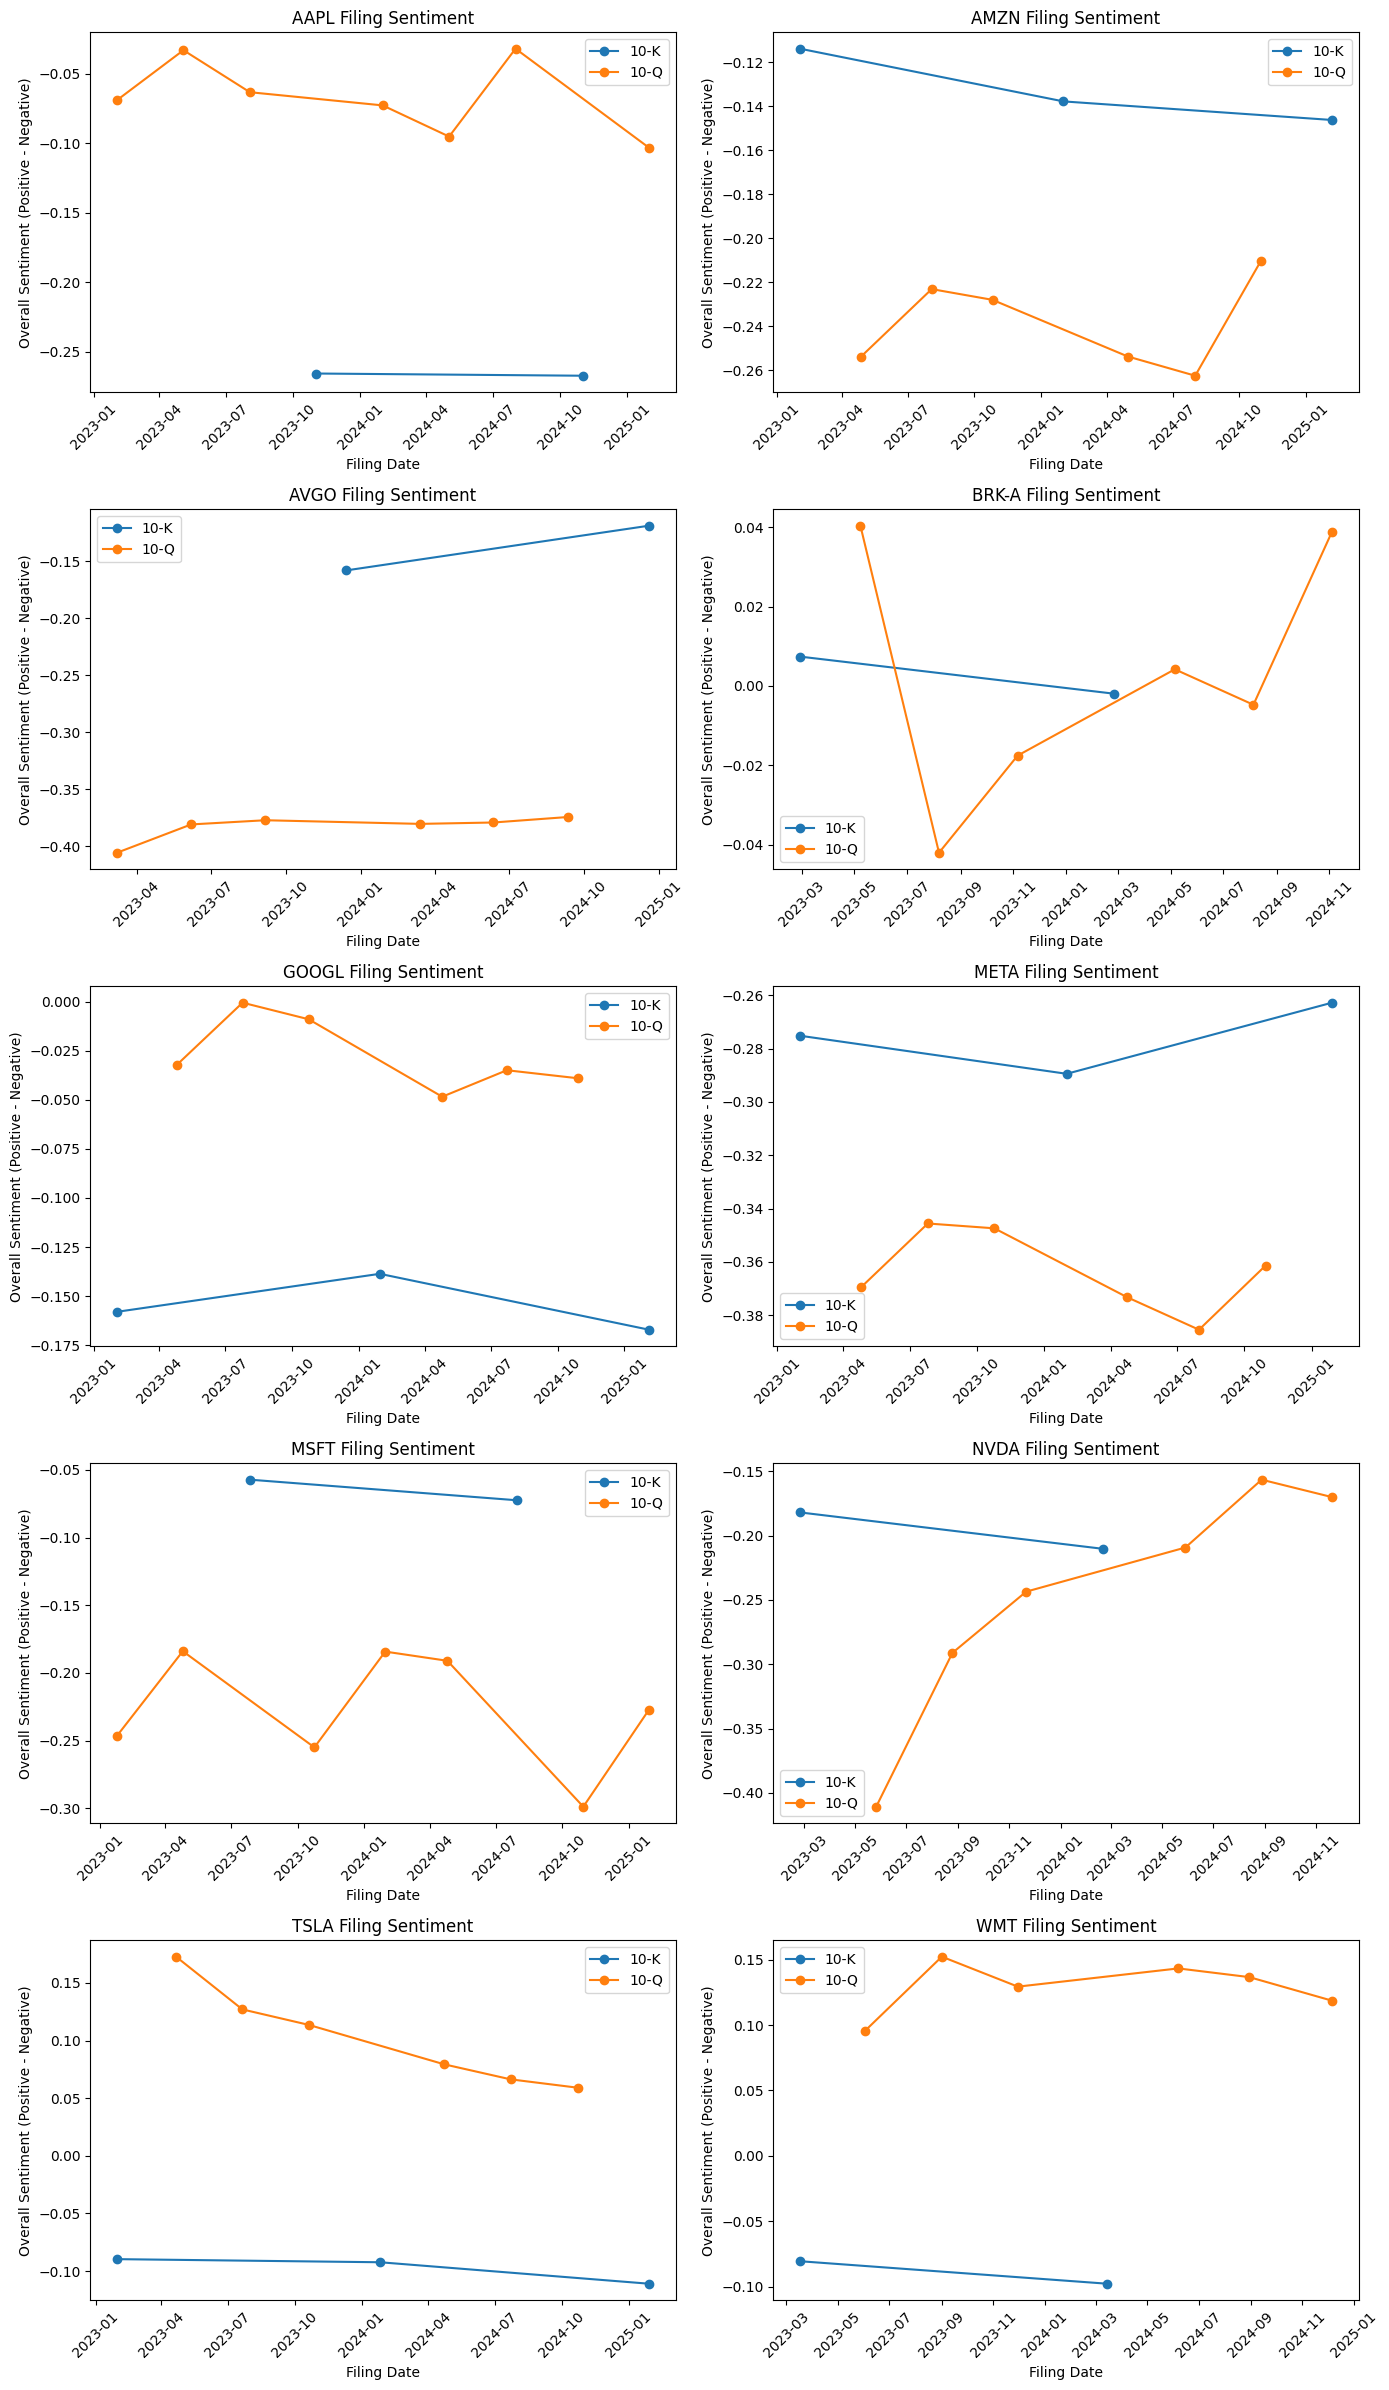

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# 회사별 CSV 파일 이름과 티커 목록
tickers = ["AAPL", "AMZN", "AVGO", "BRK-A", "GOOGL", "META", "MSFT", "NVDA", "TSLA", "WMT"]
dataframes = {}
for ticker in tickers:
    csv_file = f"metadata_{ticker}.csv"
    df = pd.read_csv(csv_file)
    df['filing_date'] = pd.to_datetime(df['filing_date'])
    df.sort_values("filing_date", inplace=True)
    dataframes[ticker] = df

# 서브플롯 생성: 5행 2열
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(14, 24))
axs = axs.flatten()

for i, ticker in enumerate(tickers):
    df = dataframes[ticker]
    df_10K = df[df["form_type"] == "10-K"]
    df_10Q = df[df["form_type"] == "10-Q"]
    
    ax = axs[i]
    if not df_10K.empty:
        ax.plot(df_10K["filing_date"], df_10K["overall"], marker='o', label="10-K")
    if not df_10Q.empty:
        ax.plot(df_10Q["filing_date"], df_10Q["overall"], marker='o', label="10-Q")
    
    ax.set_title(f"{ticker} Filing Sentiment")
    ax.set_xlabel("Filing Date")
    ax.set_ylabel("Overall Sentiment (Positive - Negative)")
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
